In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchcfm.sample_parameters import GaussianPairContainer

savedir = "models/prior-invariance"
os.makedirs(savedir, exist_ok=True)

In [3]:
gaussian_pair = GaussianPairContainer(
    prior_mu=torch.distributions.Uniform(0.0, 10),
    prior_sigma=torch.distributions.Uniform(1.0, 1.01),
    ll_mu=2.0,
    ll_sigma=1.0,
)

10: loss 0.864 time 0.08
torch.Size([500, 3])
torch.Size([100, 500, 1])
300: loss 0.454 time 1.90
torch.Size([500, 3])
torch.Size([100, 500, 1])
1000: loss 0.439 time 3.10
torch.Size([500, 3])
torch.Size([100, 500, 1])


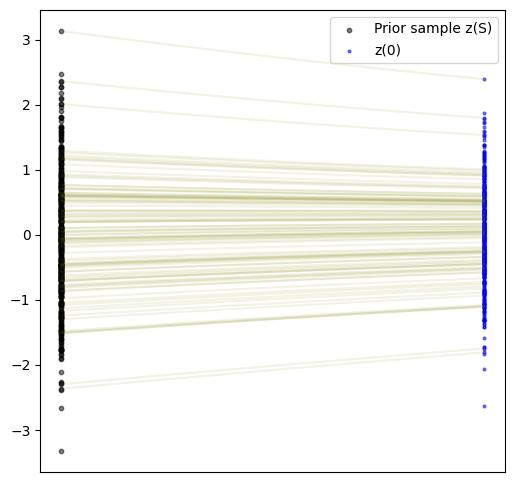

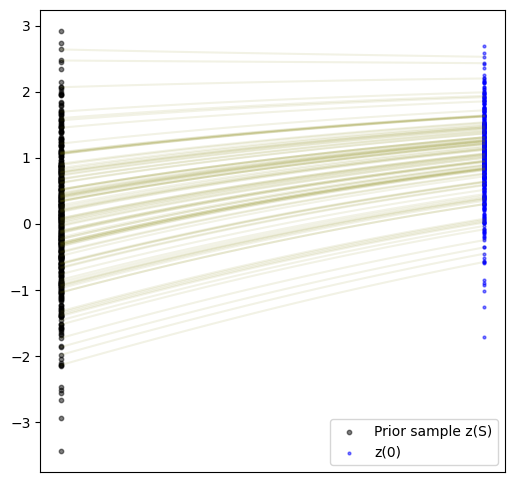

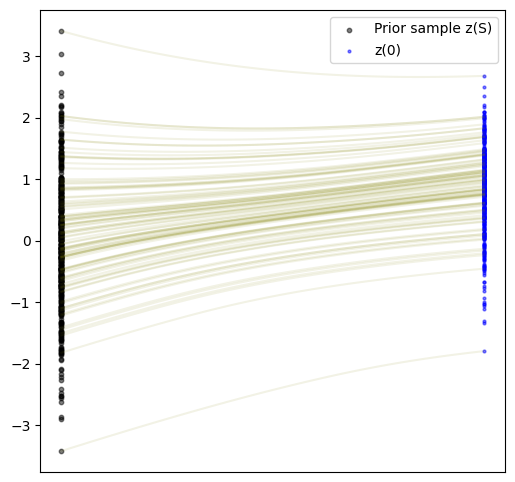

In [17]:
sigma = 0.1
dim = 1
batch_size = 256
gaussian_pair = GaussianPairContainer(
    prior_mu=torch.distributions.Uniform(0.0, 10),
    prior_sigma=torch.distributions.Uniform(1.0, 1.01),
    ll_mu=2.0,
    ll_sigma=1.0,
)

model = MLP(dim=dim+gaussian_pair.num_params, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(1000):
    optimizer.zero_grad()

    x0, x1 = gaussian_pair.sample_pair((batch_size, 1))

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    # if (k + 1) % 100 == 0:
    if (k + 1) in (10, 300, 1000):
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            samples = gaussian_pair.sample_prior(
                (500, 1),
                mu_fixed=0.0, sigma_fixed=1.0 
                )
            print(samples.shape)
            traj = node.trajectory(
                samples,
                t_span=torch.linspace(0, 1, 100),
            )[:, :, :1]
            # traj.shape = [100, 1024, dim]
            plot_trajectories_1d(
                traj.cpu().numpy(),
            )

torch.save(model, f"{savedir}/cfm_params_v1.pt")

## Invariance

Now, let's test this:

torch.Size([500, 3])
torch.Size([500, 3])


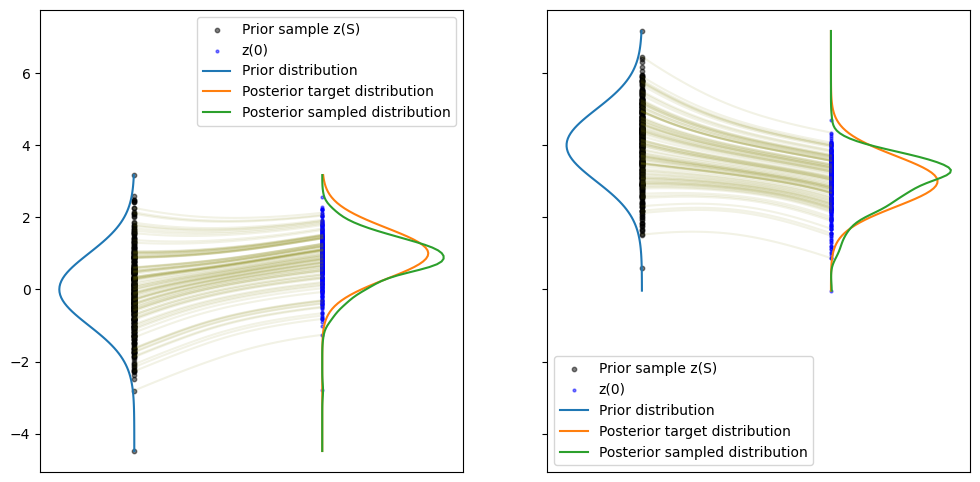

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
shifts = np.linspace(0, 4, axs.size)

model = torch.load(f"{savedir}/cfm_params_v1.pt")

for (shift, ax) in zip(shifts, axs):

    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )

    with torch.no_grad():
        samples = gaussian_pair.sample_prior(
            (500, 1),
            mu_fixed=0.0+shift, sigma_fixed=1.0 
        )
        print(samples.shape)
        traj = node.trajectory(
            samples,
            t_span=torch.linspace(0, 1, 100),
        )
        # traj.shape = [100, 1024, dim]
        prior, posterior = gaussian_pair.fixed_distributions(
            mu=0.0+shift, sigma=torch.tensor(1.0)
        )
        _ = plot_trajectories_1d(
            traj.cpu().numpy(),
            prior, posterior,
            fig=fig, ax=ax
        )
    
    
fig.savefig(f"{savedir}/dist_mismatch.pdf")